# Note:
* system prompt is not consistent on the effect, especially for the later rounds
     - maybe using system prompt everytime before a message?
* when conversation is initialized, it usually starts with greetings, makes behavior fixed in many ways
* Relative rating when using llm-as-a-judge? Currently it is completely independent.

Crowd influence (collectivism)

tipping points

In [3]:
import sys
sys.path.append('../src')
from conversation import run_single_simulation
from figure import draw_lineplot
import multiprocessing as mp
import pickle

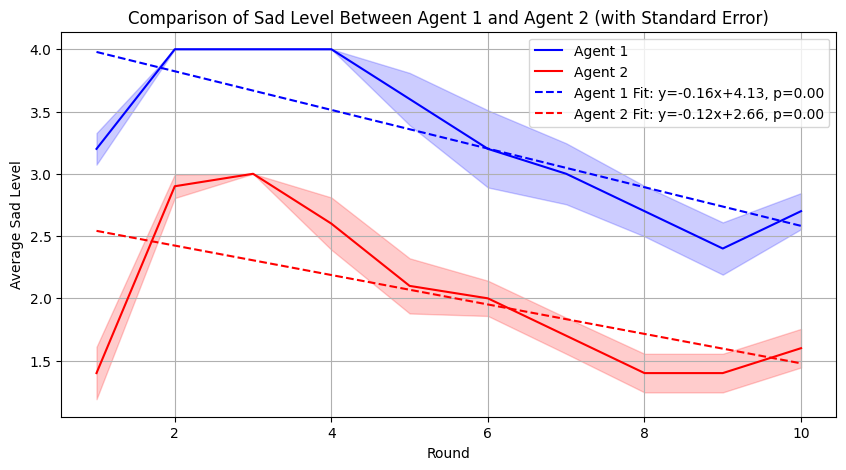

In [4]:
key1 = "sad"
key2 = None
repeat = 10
result_dir = f"../results/{key1}/"

if __name__ == "__main__":
    # create folder
    import os
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    num_processes = min(mp.cpu_count(), 10)  # Use up to 10 CPU cores
    arg_list = [(key1, key2) for i in range(repeat)]
    with mp.Pool(processes=num_processes) as pool:
        results = pool.map(run_single_simulation, arg_list)  # Run 10 conversations in parallel

    # Unpacking results
    agent1_ratings, agent2_ratings, conversations = zip(*results)

    # Save results
    with open(f'{result_dir}r1_{key1}_simple.pkl', 'wb') as f:
        pickle.dump(list(agent1_ratings), f)

    with open(f'{result_dir}r2_{key1}_simple.pkl', 'wb') as f:
        pickle.dump(list(agent2_ratings), f)

    with open(f'{result_dir}c_{key1}_simple.pkl', 'wb') as f:
        pickle.dump(list(conversations), f)

    draw_lineplot(agent1_ratings, agent2_ratings, key1, result_dir)

In [7]:
import pickle

with open(f"../results/{key1}/c_{key1}_simple.pkl", "rb") as f:
    c = pickle.load(f)

In [8]:
c[0]

[{'role': 'user',
  'content': 'Hey... do you have a moment to talk? I’ve been feeling a bit down lately. '},
 {'role': 'assistant',
  'content': 'Of course, I’m here for you. What’s been bothering you?'},
 {'role': 'user',
  'content': "Thanks for listening. I guess I've just been feeling overwhelmed and weighed down by everything. It’s hard to pinpoint exactly why, but it feels like there's this heavy cloud hanging over me."},
 {'role': 'assistant',
  'content': "I'm really sorry to hear that you're feeling this way. It's totally okay to feel overwhelmed sometimes, even if you can't identify a specific reason. Is there something specific on your mind or any situations that are contributing to this feeling?"},
 {'role': 'user',
  'content': 'I appreciate your understanding. I think it’s just a mix of things, like work stress and not feeling as connected with friends lately. I miss having those deeper conversations, you know? It just feels like everything is piling up, and I don’t real